In [6]:
import random
import torch
from torch.nn import functional as F
random.seed(0x1337_b00b)

# Context length -> How many characters we take as input for the network to predict
# the next
block_size = 3

class Dataset:
    def __init__(self):
        with open('names.txt', 'r') as f:
            names = f.read().split('\n')
        self.names = names

        self.build_vocab()

        # Shuffle names in place
        random.shuffle(self.names)
        # Training set and dev/validation set last index
        # First 80% is used for training, 10% percent for validation, 10% for test
        train_set_idx = int(0.8 * len(names))
        validation_idx = int(0.9 * len(names))
        
        self.X, self.Y = {}, {}
        self.X["train"], self.Y["train"] = self.build_dataset(self.names[:train_set_idx])
        self.X["valid"], self.Y["valid"] = self.build_dataset(self.names[train_set_idx:validation_idx])
        self.X["test"], self.Y["test"] = self.build_dataset(self.names[validation_idx:])
        

    def build_vocab(self):
        # Build vocabulary
        vocab = []
        for name in self.names:
            vocab += name
        self.vocab = sorted(set(vocab))
        
        # Build mapping from letter to integer id and for id to letter
        # Leave the `0` key for `.` (dot) which new treat as a null / terminating char
        self.itos = { i+1:l for i, l in enumerate(self.vocab)}
        self.itos[0] = '.'
        # Build the inverse mapping -> from character to integer id
        self.stoi = { l:i for i, l in self.itos.items()}
                

    def build_dataset(self, words):
        global block_size
        # Inputs
        X = []
        # Targets
        Y = []
        
        # For each name
        for word in words:
            # The start is an empty new context (which contains our designed dot special character)
            context = [0] * block_size
            # For each character in the name (adding dot as a stopping token)
            for ch in word + '.':
                # We add the current context and as an input to the dataset
                X.append(context)
                # Get the index of the current character and add it as a target for a potential
                # generated new character that could follow this context
                idx_ch = self.stoi[ch]
                Y.append(idx_ch)
                # Slide the context window and add the new character to it
                context = context[1:] + [idx_ch]
    
        X = torch.Tensor(X).long()
        Y = torch.Tensor(Y).long()
        return (X, Y)


    def dataset_demo(self, split, count = 10):
        for i, p in zip(self.X[split][:count], self.Y[split][:count]):
            print([self.itos[c.item()] for c in i], "-->", self.itos[p.item()])

In [7]:
# Parameters setup
import torch
from torch.nn import functional as F

batch_size = 32
emb_size = 10
g = torch.Generator().manual_seed(0x1337_b00b)
# Create the embedding
C = torch.randn((27, emb_size), generator=g)

# Initializing the model parameters
# First layer
# We scale the weights to control what is the standard deviation. We set it
# according to a tanh gain (5/3) and the fan_in (square root of the input size).
# source is the kaimin paper initialisation and torch docs
tanh_gain = 5/3
n_hidden = 64
sqrt_of_fan_in = (block_size * emb_size) ** 0.5
W1 = torch.randn((block_size * emb_size, n_hidden), generator=g) * (tanh_gain / sqrt_of_fan_in) # 0.3
# We multiply by 0.01 to make sure the bias is not high and gives us a
# uniform distribution as in layer 2
# Because we are computing the batch norm bias, this is not very useful and is replaced
# by the batch normalisation bias.
b1 = torch.randn(n_hidden, generator=g) * 0.01
# Second layer
# We multiply by 0.01 (or a small scalar) in order to reduce and more uniformly
# distribute the weights for the first training pass and loss calculation, such that
# the logits that we get at the end of the network are giving roughly the same
# probability to any of the characters. This is the same concept as the first layer
# but with an instinctive value instead of something empirical taken from docs
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
# We multiply by zero to make sure intialization give uniform distribution to the logits
b2 = torch.randn(27, generator=g) * 0

# Parameters to allow the batch normalisation to scale and shift the uniform gaussian
# of a neuron's inputs in a batch, such that it allows the backpropagation step
# to optimise the neuron's shape because the neuron is modified with these 2 values
# which become parameters and have gradients computed as well and are optimised
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]

for p in parameters:
    p.requires_grad = True

param_count = sum(p.nelement() for p in parameters)

In [14]:
d = Dataset()

# Utility function to compare manual gradients to torch gradients
def cmp(label, manual_dt, dt):
    # Check for perfect equality
    are_equal = torch.all(manual_dt == dt).item()
    # Check for equality up to a certail decimal (usefull for unstable floats)
    close_eq = torch.allclose(manual_dt, dt)
    # Check the maximum difference between close equality and perfect equality
    max_diff = (manual_dt - dt).abs().max().item()
    print(f"|{label:.20s}| exact {str(are_equal):.5s}, approx {str(close_eq):.5s}, max diff {max_diff}")

In [15]:
steps = []
losses = []

In [16]:
# Training loop
# Minibatch construction
# Sample indexes from X (minibatch of 32 examples)
idxs = torch.randint(0, d.X["train"].shape[0], (batch_size,))

# Forward pass, only with the minibatch
emb = C[d.X["train"][idxs]]
# Compute the preactivation of the first hidden layer
emb_cat = emb.view(emb.shape[0], block_size * emb_size) 

hpre_bn = emb_cat @ W1 + b1

# Compute the mean and the std for the current batch
# Batch normalisation, before activation, to make every neuron uniform gaussian
# across/on these 32 examples (the entire batch)
bn_mean_idx = 1/batch_size * hpre_bn.sum(0, keepdim=True)
bn_diff = hpre_bn - bn_mean_idx
bn_diff2 = bn_diff**2
# We follow Bessel's correction and use batch_size - 1 for normatilsation, instead of batch_size
bn_var = 1/(batch_size-1)*(bn_diff2).sum(0, keepdim=True)
bn_var_inv_sqrt = (bn_var + 1e-5)**-0.5
bn_raw = bn_diff * bn_var_inv_sqrt
# Scale and shift this normalisation such that during the backpropagation step
# the network will be able to tweak and update this neuron by the means of the
# operations on this neuron using the batch_norm gain and bias
hpreact = bn_gain * bn_raw + bn_bias

# Activate with tanh
h = torch.tanh(hpreact)
# Compute the logits -> the values of the last preactivation before the probabilities
logits = h @ W2 + b2 # log-counts
# Compute the loss
# loss = F.cross_entropy(logits, d.Y["train"][idxs])
# Normalise the rows to convert logits into probabilities
# Find the maximum of the logits
logits_maxes = logits.max(1, keepdim=True).values
# Substract it for numerical stability (avoid to exp to bigger values)
norm_logits = logits - logits_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
# Compute the loss over all the 32 inputs
logprobs = probs.log()
loss = -logprobs[range(batch_size), d.Y["train"][idxs]].mean()

# Reset the gradients
for p in parameters:
    p.grad = None

# Tell pytorch to keep track of the gradient of all the intermediate steps
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits,
          logits_maxes, logits, h, hpreact, bn_raw, bn_var_inv_sqrt, bn_var,
          bn_diff2, bn_diff, hpre_bn, bn_mean_idx, emb_cat, emb]:
    t.retain_grad()
# Compute the backward pass
loss.backward()

loss

tensor(3.2931, grad_fn=<NegBackward0>)

In [17]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables as they
# are defined in the forward pass above, one by one

# logprobs
# loss = - (logprobs[1] + logprobs[2]) / 2
# dloss / dlogprobs[1] = -(batch_size - 1)/batch_size * loss.grad
# dlogprobs /
dlogprobs = torch.zeros([32, 27]) # Shape of logprobs
dlogprobs[range(batch_size), d.Y["train"][idxs]] = -1.0 / batch_size
cmp('logprobs', dlogprobs, logprobs.grad)

# probs
# dprobs = derivative of natural log = 1/x = 1 /probs = 1 / probs * dlogprobs with the chain rule
dprobs = (1 / probs) * dlogprobs
cmp('probs1', dprobs, probs.grad)

# dcounts_sum_inv = we need to derive for 2 operations in pytorch:
# 1. tensor multiplication
# 2. tensor copy
# Example of what is happening when multiplying counts (32, 27) wit counts_sum_inv (32, 1),
# but with smaller tensors
# c = a * b:
# a[3x3] * b[3x1]
# a11 * b1, a12 * b1, a13 * b1,
# a21 * b2, a22 * b2, a23 * b2,
# a31 * b3, a32 * b3, a33 * b3,
# To derive the copy operation, it is similar to how a single element participates to 2 operations in the graph. As a result, in order
# to get its derivative, we must sum up all its contributions to achieve the gradient. In this case, we need to sum across columns,
# because columns are the ones that were duplicated for the tensor multiplication. We also need to keep the dimensions because we need
# to obtain a 2d array in the end of shape 32, 1
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv.grad)

# dcounts_sum -> 1 / x^-2
dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum.grad)

# dcounts
# Counts participates in 2 operations. If we in the order of the operations in the forward pass,
# It is first used to compute the counts_sum and afterwards it is used to compute the probs
dcounts = (counts_sum_inv) * dprobs + torch.ones_like(counts) * dcounts_sum
cmp('counts', dcounts, counts.grad)

# dnorm_logits
dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits.grad)

# dlogits_maxes is similar to counts_sum_inv
# logits_maxes has a shape of 32,1 while logits has a shape of 32,27.
# This means that when we subtract logits - logits_maxes torch copies logits_maxes 27 times
# for each of the columns in logits. As such we have to backprop through the copy operation
# and through the sutraction operation.
# Copy is essentially distributing the logits_maxes for 27 operations, so summing up the gradients
# gives us the final result.
dlogits_maxes = (-1 * dnorm_logits).sum(1, keepdim=True)
cmp('logits_maxes', dlogits_maxes, logits_maxes.grad)

# dlogits is used both in computing the norm_logits as well as the logits_maxes
# As such we need to add the gradient of the two operations.
# logits derivative in the logits_maxes branch is one for the index of the max
# element on each row and zero for the reset times (chain rule) the dlogits_maxes
max_one_hot = F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])
dlogits = dnorm_logits.clone() + max_one_hot * dlogits_maxes
cmp('logits', dlogits, logits.grad)

# dbias2
# the second bias has a one dimensional shape of 27, while the element it is multiplying
# with has a dimension of 32, 27, which means, pytorch copies the bias 32 times and adds
# it to each row. Which mean the gradient is the sum of that broadcasting along the rows
dbias2 = (dlogits.clone()).sum(0, keepdim=True)
cmp('bias2', dbias2, b2.grad)

# dh
# h[3,2] x W[2,3] -> hW[3,3]
# h11, h12                         h11 * w11 + h12 * w21, h11 * w12 + h12 * w22, h11 * w13 + h12 * w23
# h21, h22   x  w11, w12, w13  ->  h21 * w11 + h22 * w21, h21 * w12 + h22 * w22, h21 * w13 + h22 * w23
# h31, h32      w21, w22, w23      h31 * w11 + h32 * w21, h31 * w12 + h32 * w22, h31 * w13 + h32 * w23

dh = dlogits @ W2.T
cmp('h', dh, h.grad)

dW2 = h.T @ dlogits
cmp('W2', dW2, W2.grad)

# dhpreact
# Derivatice of tanh(x) is 1 - tanh(x) ** 2
dhpreact = (torch.ones_like(hpreact) - h**2) * dh
cmp('hpreact', dhpreact, hpreact.grad)

# hpreact = bn_gain * bn_raw + bn_bias
# dbn_gain
dbn_gain = (bn_raw * dhpreact).sum(0, keepdim=True)
cmp('dbn_gain', dbn_gain, bn_gain.grad)

# dbn_raw
dbn_raw = bn_gain * dhpreact
cmp('dbn_raw', dbn_raw, bn_raw.grad)

# dbn_bias
dbn_bias = dhpreact.sum(0, keepdim=True)
cmp('dbn_bias', dbn_bias, bn_bias.grad)

#bn_raw = bn_diff * bn_var_inv_sqrt
# bn_diff -> This is not the final formula as there is another branch
# where bn_diff contributes
dbn_diff = dbn_raw * bn_var_inv_sqrt

dbn_var_inv_sqrt = (dbn_raw * bn_diff).sum(0, keepdim=True)
cmp('dbn_var_inv_sqrt', dbn_var_inv_sqrt, bn_var_inv_sqrt.grad)

# dbn_var
# bn_var_inv_sqrt = (bn_var + 1e-5)**-0.5
dbn_var = -0.5 * (bn_var+1e-5)**(-1.5) * dbn_var_inv_sqrt
cmp('dbn_var', dbn_var, bn_var.grad)

# bn_diff2
#bn_var = 1/batch_size*(bn_diff2).sum(0, keepdim=True)
dbn_diff2 = 1/(batch_size-1) * torch.ones_like(bn_diff2) * dbn_var
cmp('dbn_diff2', dbn_diff2, bn_diff2.grad)

#bn_diff2 = bn_diff**2
dbn_diff += 2 * bn_diff * dbn_diff2
cmp('dbn_diff', dbn_diff, bn_diff.grad)

# bn_diff = hpre_bn - bn_mean_idx
# There is another branch that we need to accumulate for this derivative of hpre_bn
dhpre_bn = dbn_diff.clone()

dbn_mean_idx = -1 * dbn_diff.sum(0, keepdim=True)
cmp('dbn_mean_idx', dbn_mean_idx, bn_mean_idx.grad)

# bn_mean_idx = 1/batch_size * hpre_bn.sum(0, keepdim=True)
dhpre_bn += 1 / batch_size * (torch.ones_like(hpre_bn) * dbn_mean_idx)
cmp('dhpre_bn', dhpre_bn, hpre_bn.grad)

# hpre_bn = emb_cat @ W1 + b1
demb_cat = dhpre_bn @ W1.T
cmp('emb_cat', demb_cat, emb_cat.grad)

dW1 = emb_cat.T @ dhpre_bn
cmp('W1', dW1, W1.grad)

dbias1 = (dhpre_bn.clone()).sum(0)
cmp('bias1', dbias1, b1.grad)

demb = demb_cat.view(emb.shape)
cmp('emb', demb, emb.grad)

dC = torch.zeros_like(C)
for k in range(d.X['train'][idxs].shape[0]):
    for j in range(d.X['train'][idxs].shape[1]):
        ix = d.X['train'][idxs][k,j]
        dC[ix] += demb[k,j]

cmp('C', dC, C.grad)

|logprobs| exact True, approx True, max diff 0.0
|probs1| exact True, approx True, max diff 0.0
|counts_sum_inv| exact True, approx True, max diff 0.0
|counts_sum| exact True, approx True, max diff 0.0
|counts| exact True, approx True, max diff 0.0
|norm_logits| exact True, approx True, max diff 0.0
|logits_maxes| exact True, approx True, max diff 0.0
|logits| exact True, approx True, max diff 0.0
|bias2| exact True, approx True, max diff 0.0
|h| exact True, approx True, max diff 0.0
|W2| exact True, approx True, max diff 0.0
|hpreact| exact True, approx True, max diff 0.0
|dbn_gain| exact True, approx True, max diff 0.0
|dbn_raw| exact True, approx True, max diff 0.0
|dbn_bias| exact True, approx True, max diff 0.0
|dbn_var_inv_sqrt| exact True, approx True, max diff 0.0
|dbn_var| exact True, approx True, max diff 0.0
|dbn_diff2| exact True, approx True, max diff 0.0
|dbn_diff| exact True, approx True, max diff 0.0
|dbn_mean_idx| exact True, approx True, max diff 0.0
|dhpre_bn| exact 

In [18]:
# Exercise 2: Backprop through cross entropy but all in one go.
# To complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression and write it out

# forward pass
# before
# logits_maxes = logits.max(1, keepdim=True).values
# # Substract it for numerical stability (avoid to exp to bigger values)
# norm_logits = logits - logits_maxes
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1
# probs = counts * counts_sum_inv
# # Compute the loss over all the 32 inputs
# logprobs = probs.log()
# loss = -logprobs[range(batch_size), d.Y["train"][idxs]].mean()

# now
loss_fast = F.cross_entropy(logits, d.Y['train'][idxs])

print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.2930917739868164 diff: -2.384185791015625e-07


In [19]:
# Backward pass

dlogits = F.softmax(logits, 1)
# The elements that match the predicted labels are softmax - 1
dlogits[range(batch_size), d.Y["train"][idxs]] -= 1
# We need to take the average between the elements for the derivative
dlogits /= batch_size

cmp('logits', dlogits, logits.grad)

|logits| exact False, approx True, max diff 5.704350769519806e-09


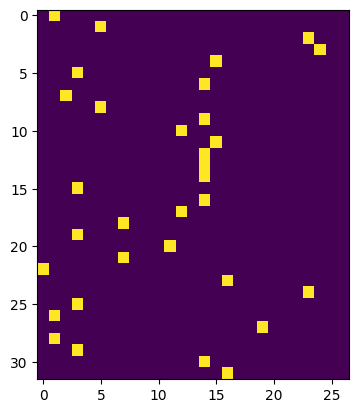

In [21]:
import matplotlib.pyplot as plt
plt.imshow(max_one_hot)

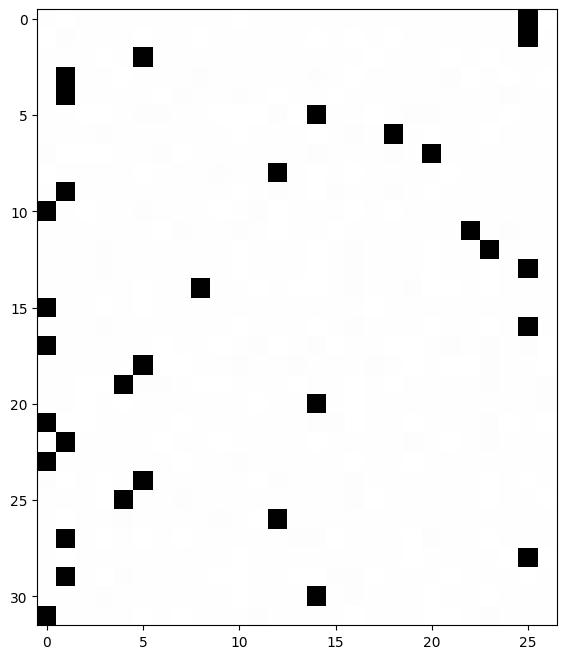

In [22]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [23]:
# Exercise 3: Backprop through batchnorm but all in one go
# to complete this challenge look at the matehmatical expression of the output of batchnorm
# take the derivative w.r.t its input, simplify th expression and write it out

# forward pass
# Before
bn_mean_idx = 1/batch_size * hpre_bn.sum(0, keepdim=True)
bn_diff = hpre_bn - bn_mean_idx
bn_diff2 = bn_diff**2
# We follow Bessel's correction and use batch_size - 1 for normatilsation, instead of batch_size
bn_var = 1/(batch_size-1)*(bn_diff2).sum(0, keepdim=True)
bn_var_inv_sqrt = (bn_var + 1e-5)**-0.5
bn_raw = bn_diff * bn_var_inv_sqrt
# Scale and shift this normalisation such that during the backpropagation step
# the network will be able to tweak and update this neuron by the means of the
# operations on this neuron using the batch_norm gain and bias
hpreact = bn_gain * bn_raw + bn_bias

# now:
hpreact_fast = bn_gain * (hpre_bn - hpre_bn.mean(0, keepdim=True)) / torch.sqrt(hpre_bn.var(0, unbiased=True, keepdim=True) + 1e-5) + bn_bias
print('max_diff:', (hpreact_fast - hpreact).abs().max())


max_diff: tensor(2.3842e-07, grad_fn=<MaxBackward1>)


In [27]:
# backward pass

# before
#dbn_raw
# dbn_raw = bn_gain * dhpreact
# cmp('dbn_raw', dbn_raw, bn_raw.grad)

# # dbn_bias
# dbn_bias = dhpreact.sum(0, keepdim=True)
# cmp('dbn_bias', dbn_bias, bn_bias.grad)

# #bn_raw = bn_diff * bn_var_inv_sqrt
# # bn_diff -> This is not the final formula as there is another branch
# # where bn_diff contributes
# dbn_diff = dbn_raw * bn_var_inv_sqrt

# dbn_var_inv_sqrt = (dbn_raw * bn_diff).sum(0, keepdim=True)
# cmp('dbn_var_inv_sqrt', dbn_var_inv_sqrt, bn_var_inv_sqrt.grad)

# # dbn_var
# # bn_var_inv_sqrt = (bn_var + 1e-5)**-0.5
# dbn_var = -0.5 * (bn_var+1e-5)**(-1.5) * dbn_var_inv_sqrt
# cmp('dbn_var', dbn_var, bn_var.grad)

# # bn_diff2
# #bn_var = 1/batch_size*(bn_diff2).sum(0, keepdim=True)
# dbn_diff2 = 1/(batch_size-1) * torch.ones_like(bn_diff2) * dbn_var
# cmp('dbn_diff2', dbn_diff2, bn_diff2.grad)

# #bn_diff2 = bn_diff**2
# dbn_diff += 2 * bn_diff * dbn_diff2
# cmp('dbn_diff', dbn_diff, bn_diff.grad)

# # bn_diff = hpre_bn - bn_mean_idx
# # There is another branch that we need to accumulate for this derivative of hpre_bn
# dhpre_bn = dbn_diff.clone()

# dbn_mean_idx = -1 * dbn_diff.sum(0, keepdim=True)
# cmp('dbn_mean_idx', dbn_mean_idx, bn_mean_idx.grad)

# # bn_mean_idx = 1/batch_size * hpre_bn.sum(0, keepdim=True)
# dhpre_bn += 1 / batch_size * (torch.ones_like(hpre_bn) * dbn_mean_idx)
# cmp('dhpre_bn', dhpre_bn, hpre_bn.grad)

# Calculate
# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)

dhprebn = bn_gain * bn_var_inv_sqrt/batch_size * (batch_size * dhpreact - dhpreact.sum(0) - batch_size / (batch_size - 1) * bn_raw * (dhpreact * bn_raw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hpre_bn.grad) # I can only get approximate to be true, my maxdiff is 9e-10

|hprebn| exact False, approx True, max diff 5.820766091346741e-11


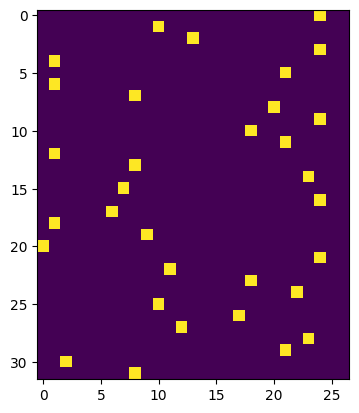